In [3]:
import pandas as pd
import numpy as np
import math

In [4]:
from sklearn.model_selection import KFold, GridSearchCV

## misc function

In [5]:
def train_test_split(X, y, test_p=0.25, random_state=42):
    ids = np.unique(X.index.values)
    test_size = math.floor(test_p * len(ids))
    test_index = np.random.choice(ids, size=test_size)
    X_train = X[~X.index.isin(test_index)]
    X_test = X[X.index.isin(test_index)]
    y_train = y[~y.index.isin(test_index)]
    y_test = y[y.index.isin(test_index)]
    return X_train, X_test, y_train, y_test

In [6]:
data = pd.read_csv('/projects/eerhan_prj/eerhan_prj_results/pog500_expression/results/04_02_250103127/data/All_CARBOPLATIN.tsv', sep='\t', index_col=0)

In [7]:
data = data.drop_duplicates()

In [8]:
X_columns = data.columns.values[pd.Series(data.columns.values).str.contains('ENSG')]

In [9]:
X = data.loc[:, X_columns]

In [10]:
y = data.loc[:, 'y_trans']
y_discrete = y > 0

In [11]:
kf = KFold(n_splits=5)
kf.get_n_splits(X)

5

## RBF

In [12]:
from sklearn.svm import SVC, SVR

In [13]:
from scipy.stats import spearmanr

In [14]:
print('SVC with linear kernel')
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y_discrete[train_index], y_discrete[test_index]
    svc_rbf = SVC(C=10, kernel='linear', gamma='auto')
    svc_rbf.fit(X_train, y_train)
    print(svc_rbf.score(X_test, y_test))

SVC with linear kernel
0.7142857142857143
0.5714285714285714
0.5714285714285714
0.7857142857142857
0.9285714285714286


In [15]:
print('SVR with RBF')
corrs = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y[train_index], y[test_index]
    svr_rbf = SVR(C=10, kernel='linear', gamma='auto')
    svr_rbf.fit(X_train, y_train)
    y_pred = svr_rbf.predict(X_test)
    corrs.append(spearmanr(y_pred, y_test))
    print(svr_rbf.score(X_test, y_test))

SVR with RBF
-0.9869023190412294
-11.163915354874906
-0.6442514075476506
-6.798132153829639
-18.405856094431872


In [16]:
[(x.correlation, x.pvalue) for x in corrs]

[(-0.057205755188472505, 0.8459835436129705),
 (-0.541254452937086, 0.0456258832832993),
 (0.21122124992666771, 0.4685287980154579),
 (0.3392078713158676, 0.23544250342973244),
 (0.054945054945054944, 0.8520077036323677)]

In [18]:
corrs

[SpearmanrResult(correlation=-0.057205755188472505, pvalue=0.8459835436129705),
 SpearmanrResult(correlation=-0.541254452937086, pvalue=0.0456258832832993),
 SpearmanrResult(correlation=0.21122124992666771, pvalue=0.4685287980154579),
 SpearmanrResult(correlation=0.3392078713158676, pvalue=0.23544250342973244),
 SpearmanrResult(correlation=0.054945054945054944, pvalue=0.8520077036323677)]

In [19]:
weights = pd.DataFrame(data={'weights': svc_rbf.coef_[0],
                   'names': data.columns[:-3]})

In [20]:
weights['weights'] = np.abs(weights['weights'])

In [21]:
weights.sort_values('weights')

,weights,names
147,5.507695e-18,ENSG00000277213
81,5.507695e-18,ENSG00000230009
129,1.538252e-17,ENSG00000258683
148,9.746363e-17,ENSG00000279558
80,2.863596e-16,ENSG00000229310
...,...,...
26,7.902204e-02,ENSG00000152242
113,7.960063e-02,ENSG00000250207
64,8.453450e-02,ENSG00000217331
43,8.815487e-02,ENSG00000175701


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [23]:
svc_rbf = SVR(C=10, kernel='linear', gamma='auto')
svc_rbf.fit(X_train, y_train)
svc_rbf.score(X_test, y_test)

-8.367600197054397

In [24]:
params = {"C":[0.1, 1, 10, 50], "gamma": [0.1, 0.01, 0.001, 1, 10]}
grid_search = GridSearchCV(svc_rbf, params,cv=5)
grid_search.fit(X_train,y_train)

/projects/eerhan_prj/anaconda/envs/data/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVR(C=10, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='auto', kernel='linear',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 50],
                         'gamma': [0.1, 0.01, 0.001, 1, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [25]:
grid_search.score(X_test, y_test)

-8.367600197054397

### PCA/ t-SNE

In [26]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [27]:
pca = PCA(n_components=10)

In [28]:
pca_expression = pca.fit_transform(X)

In [29]:
pca_expression_df = pd.DataFrame(pca_expression, columns=['PC{}'.format(i) for i in range(1, 11)], index=X.index)

In [30]:
pca_expression_df['y_trans'] = data['y_trans']
pca_expression_df['y'] = data['y']
pca_expression_df['discrete'] = [1 if x else 0 for x in y_discrete]

In [31]:
tsne = TSNE(n_components=3)

In [32]:
tsne_expression = tsne.fit_transform(pca_expression)

In [33]:
tsne_expression_df = pd.DataFrame(tsne_expression, columns=['tsne{}'.format(i) for i in range(1, 4)], index=X.index)

In [34]:
tsne_expression_df['y_trans'] = data['y_trans']
tsne_expression_df['y'] = data['y']
tsne_expression_df['discrete'] = [1 if x else 0 for x in y_discrete]

## Try to explain with cancer type

In [35]:
from matplotlib import pyplot as plt
import seaborn as sns

In [36]:
drugs_df = pd.read_csv('../data/processed/drugs_filtered.tsv', sep='\t', index_col=0)

In [37]:
cancer_map = drugs_df[['pog_id', 'cancer_cohort']]

In [38]:
data = cancer_map.join(data, on='pog_id', how='right').drop_duplicates().sort_values('pog_id')

In [39]:
data = data.set_index('pog_id')

In [40]:
data

,cancer_cohort,ENSG00000015568,ENSG00000023909,ENSG00000039068,ENSG00000040199,ENSG00000051596,ENSG00000060749,ENSG00000081985,ENSG00000089177,ENSG00000100253,...,ENSG00000275489,ENSG00000276406,ENSG00000276443,ENSG00000276668,ENSG00000277213,ENSG00000279558,ENSG00000283408,y,y_trans,y_pred
pog_id,,,,,,,,,,,,,,,,,,,,,
POG002,BRCA,-0.106563,-0.748857,-0.327301,-0.860613,-1.050185,-1.091186,-0.346278,-0.619761,-0.208754,...,-0.052448,-0.085391,0.354517,-0.319078,-0.041922,-0.072072,-0.069182,105,0.272834,NaN
POG011,COLO,-0.106563,3.866762,-0.264711,-0.905075,0.416752,-0.109545,-0.269279,-0.301210,-0.240696,...,-0.052448,-0.085391,-0.031168,1.128367,-0.041922,-0.072072,-0.069182,298,1.745135,True
POG020,CNS-PNS,-0.106563,-0.206204,-0.797031,0.735602,0.723897,0.156380,-0.223869,0.095235,-0.290891,...,-0.052448,-0.085391,0.002631,0.530509,-0.041922,-0.072072,-0.069182,44,-0.715317,False
POG032,BRCA,-0.106563,-0.585720,-0.870439,-0.767241,-1.033388,-0.718892,-0.338381,-0.935987,-0.286328,...,-0.000034,-0.085391,-0.048299,-0.319078,-0.041922,-0.072072,-0.069182,439,2.386641,NaN
POG038,OV,-0.106563,0.080480,0.082070,0.064214,6.150926,0.201967,-0.324560,-0.794151,-0.222444,...,-0.052448,-0.085391,-0.082793,-0.067349,-0.041922,-0.072072,0.044987,28,-1.157017,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
POG777,OV,7.486017,0.425184,0.410992,0.264296,7.842623,-0.791831,-0.289022,-0.219828,9.688808,...,-0.052448,-0.085391,-0.114509,0.184381,-0.041922,-0.072072,0.547330,56,-0.460508,NaN
POG814,LUNG,-0.106563,-0.277193,-0.114373,-0.616067,-0.882215,-0.448409,-0.336406,-0.662777,-0.080985,...,-0.039344,-0.085391,23.296743,-0.319078,-0.041922,-0.072072,-0.069182,227,1.326943,NaN
POG816,BRCA,-0.106563,-0.163202,0.210685,-0.131423,-0.494285,-0.414978,-0.314689,2.516921,-0.172248,...,-0.039344,-0.085391,-0.112194,-0.319078,-0.041922,-0.072072,0.044987,48,-0.624980,NaN


In [41]:
data['y_true'] = data['y_trans'] > 0

In [42]:
# data.to_csv('../ismb_poster/gemcitabine.tsv', sep='\t')

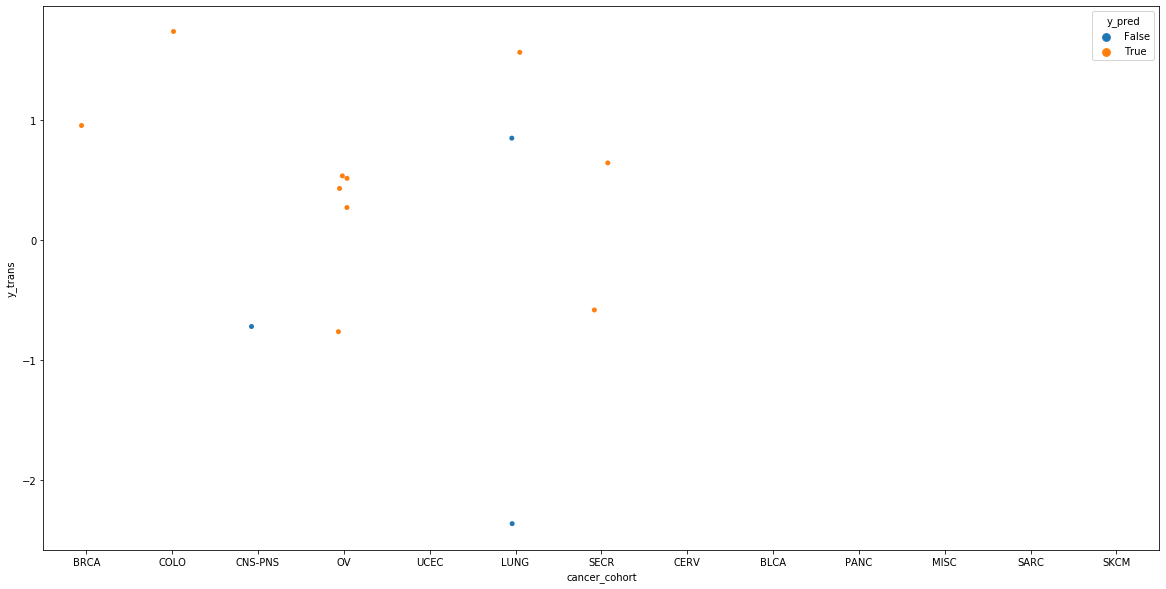

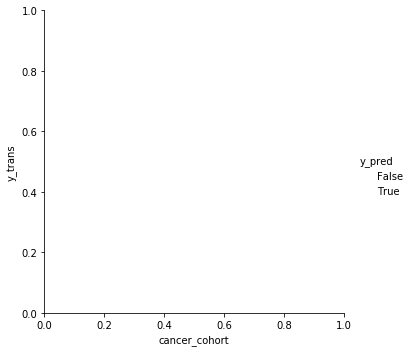

In [43]:
fig, ax = plt.subplots(figsize=(20,10))
sns.catplot(data=data, ax=ax, x='cancer_cohort', y='y_trans', hue='y_pred')

## Try BRCA GEM

In [44]:
brca_data = data[data['cancer_cohort'] == 'BRCA']

In [45]:
data = brca_data

In [46]:
X_columns = data.columns.values[pd.Series(data.columns.values).str.contains('ENSG')]

In [47]:
X = data.loc[:, X_columns]

In [48]:
y = data.loc[:, 'y_trans']
y_discrete = y > 0

In [49]:
kf = KFold(n_splits=5)
kf.get_n_splits(X)

5

## RBF

In [267]:
from sklearn.svm import SVC, SVR

In [268]:
from scipy.stats import spearmanr

In [269]:
print('SVC with linear kernel')
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y_discrete[train_index], y_discrete[test_index]
    svc_rbf = SVC(C=1, kernel='linear', gamma='auto')
    svc_rbf.fit(X_train, y_train)
    print(svc_rbf.score(X_test, y_test))

SVC with linear kernel
0.7272727272727273
0.6363636363636364
0.5454545454545454
0.9090909090909091
0.6363636363636364


In [270]:
print('SVR with linear kernel')
corrs = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y[train_index], y[test_index]
    svr_rbf = SVR(C=10, kernel='linear', gamma='auto')
    svr_rbf.fit(X_train, y_train)
    y_pred = svr_rbf.predict(X_test)
    corrs.append(spearmanr(y_pred, y_test))
    print(svr_rbf.score(X_test, y_test))

SVR with linear kernel
-2.0797387205826086
-0.47080247193205943
-0.24166275156452754
-1.1844386731756478
0.11960368996595483


In [271]:
[(x.correlation, x.pvalue) for x in corrs]

[(0.2876742319356506, 0.39100355454086044),
 (0.3698630136986301, 0.262893732707693),
 (0.5181818181818182, 0.10249153979096383),
 (-0.04187178946793119, 0.9027128456856279),
 (0.6727272727272727, 0.023313039833185972)]

In [272]:
corrs

[SpearmanrResult(correlation=0.2876742319356506, pvalue=0.39100355454086044),
 SpearmanrResult(correlation=0.3698630136986301, pvalue=0.262893732707693),
 SpearmanrResult(correlation=0.5181818181818182, pvalue=0.10249153979096383),
 SpearmanrResult(correlation=-0.04187178946793119, pvalue=0.9027128456856279),
 SpearmanrResult(correlation=0.6727272727272727, pvalue=0.023313039833185972)]

### Visualize

In [50]:
sns.set(rc={'figure.figsize':(10,10)})

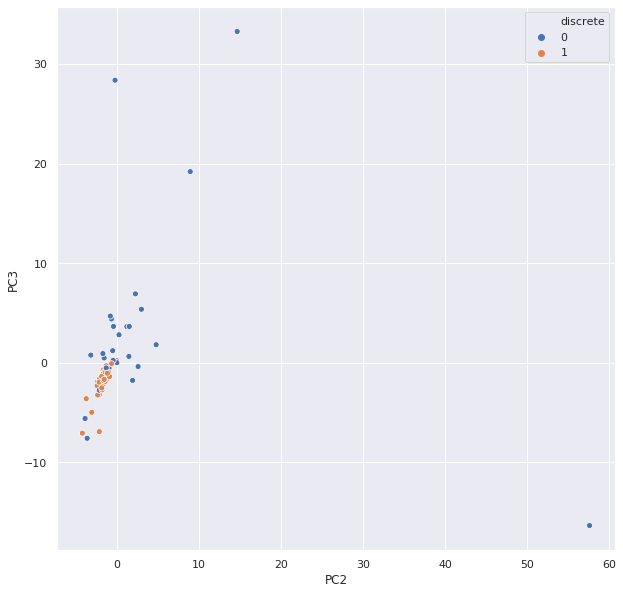

In [51]:
sns.scatterplot(data=pca_expression_df, x='PC2', y='PC3', hue='discrete')
plt.show()

In [52]:
visualize = pca_expression_df.loc[:, ['PC{}'.format(i) for i in range(1, 5)]+['discrete']]

In [53]:
visualize

,PC1,PC2,PC3,PC4,discrete
pog_id,,,,,
POG002,-2.764016,-2.035394,-3.168792,1.678373,1
POG011,-1.502497,-0.721978,-0.215558,-0.822798,1
POG020,-0.821579,-1.569579,0.468155,-1.216003,0
POG032,-3.929284,-3.078237,-4.997961,2.901921,1
POG038,1.434031,-1.720519,0.906210,0.093610,0
...,...,...,...,...,...
POG777,63.626022,-3.643095,-7.604338,5.947212,0
POG814,-4.761329,-4.226777,-7.085365,5.248060,1
POG816,-1.794812,-0.526380,1.198024,-3.351050,0


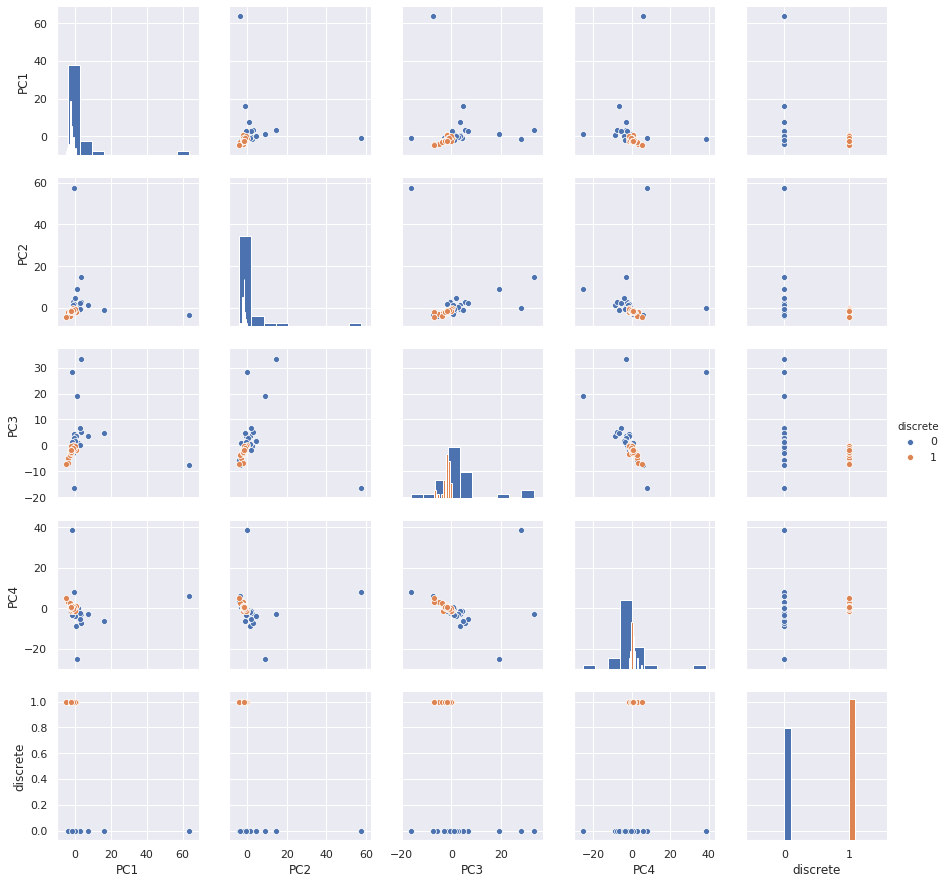

In [54]:
sns.pairplot(visualize, hue='discrete', diag_kind='hist')
plt.show()

In [55]:
pca.explained_variance_ratio_

array([0.0967197 , 0.0806047 , 0.06436244, 0.05400104, 0.04642929,
       0.04421839, 0.04269599, 0.04042937, 0.03916604, 0.03858418])

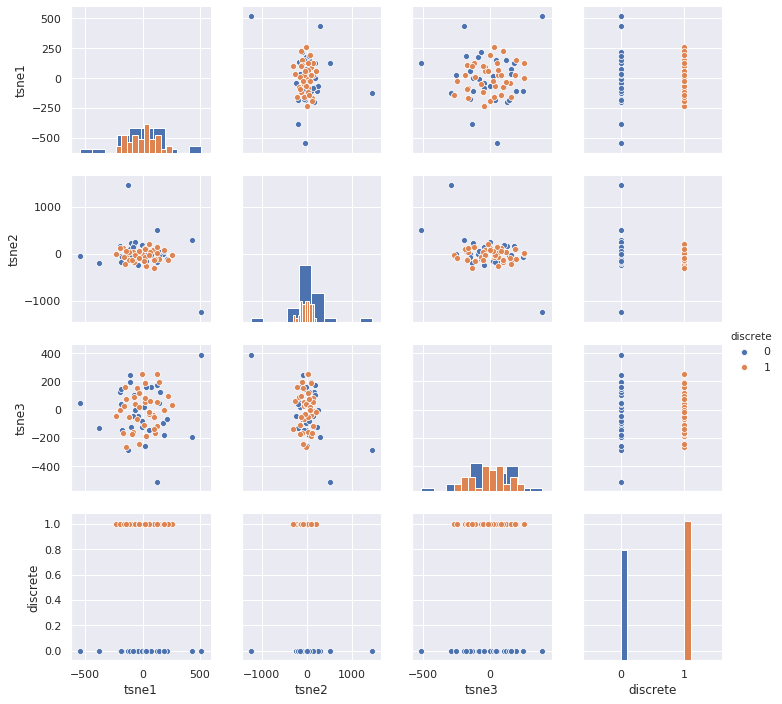

In [56]:
sns.pairplot(tsne_expression_df.loc[:,['tsne{}'.format(i) for i in range(1, 4)]+['discrete']] , hue='discrete', diag_kind='hist')
plt.show()